In [26]:
# 🧠 Cell 1: Core Libraries
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image
from collections import deque
import numpy as np
import pathlib


In [11]:
# 🌱 Cell 2: Reproducibility
random.seed(42)
torch.manual_seed(42)


In [12]:
# 📂 Cell 3: Project Paths
PROJECT_ROOT = pathlib.Path(os.getcwd()).resolve().parent
DATA_DIR = PROJECT_ROOT / "data" / "preprocessed" / "fertilizer" / "YaraMila"
IMAGE_DIR = str(DATA_DIR)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = (128, 128)
NUM_EPISODES = 5
MAX_STEPS = 20
LR = 1e-4
THRESHOLD = 0.0148  # ← you can inject from settings.yaml if preferred

print(f"🛠 Using image folder: {IMAGE_DIR}")


🛠 Using image folder: D:\Documents\CODE_WITH_ERICADESHH\GitHub\HarvestGuard\data\preprocessed\fertilizer\YaraMila


In [14]:
# 🔍 Cell 4: Load Trained Autoencoder with Scoring Logic

import sys

# Add project root to sys.path so we can import from models/
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from models.autoencoder import ConvAutoencoder

# Load the autoencoder
autoencoder = ConvAutoencoder().to(DEVICE)
autoencoder_path = PROJECT_ROOT / "models" / "checkpoints" / "autoencoder.pth"
autoencoder.load_state_dict(torch.load(autoencoder_path, map_location=DEVICE))
autoencoder.eval()

# Scoring function (MSE)
def anomaly_score(img_tensor):
    with torch.no_grad():
        recon = autoencoder(img_tensor)
        return torch.nn.functional.mse_loss(recon, img_tensor).item()


In [15]:
# 🧪 Cell 5: Enhanced RL Environment with anomaly scoring

class SmarterImageScanEnv:
    def __init__(self, image_dir, autoencoder_model):
        self.image_dir = image_dir
        self.autoencoder = autoencoder_model
        self.index = 0

        if not os.path.exists(image_dir):
            raise FileNotFoundError(f"❌ Directory not found: {image_dir}")

        self.images = sorted([
            f for f in os.listdir(image_dir)
            if f.lower().endswith(('.jpg', '.png', '.jpeg'))
        ])

        if not self.images:
            raise ValueError(f"❌ No valid image files in: {image_dir}")

        self.transform = transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            transforms.ToTensor()
        ])

    def reset(self):
        self.index = 0
        return self._get_obs()

    def _get_obs(self):
        if self.index >= len(self.images):
            return None
        path = os.path.join(self.image_dir, self.images[self.index])
        image = Image.open(path).convert("RGB")
        return self.transform(image).unsqueeze(0).to(DEVICE)

    def step(self, action):
        """Action: 0 = mark as REAL, 1 = mark as FAKE"""
        img_tensor = self._get_obs()

        # Compute anomaly score (lower = more real)
        score = anomaly_score(img_tensor)
        threshold = 0.0148  # Ideally this should be dynamic/configurable

        is_anomaly = score > threshold
        user_feedback = 1 if is_anomaly else 0  # Simulated

        # Reward logic
        if action == 1 and is_anomaly:
            reward = +1  # Correctly flagged fake
        elif action == 0 and not is_anomaly:
            reward = +1  # Correctly identified real
        else:
            reward = -1  # Wrong classification

        self.index += 1
        done = self.index >= len(self.images)
        return self._get_obs(), reward, done


In [17]:
# 🏋️ Cell 6: Setup training with smarter environment
# 🤖 Cell X: Define Enhanced Agent
class Agent(nn.Module):
    def __init__(self, input_shape=(3, 128, 128), num_actions=2):
        super(Agent, self).__init__()
        c, h, w = input_shape
        self.net = nn.Sequential(
            nn.Conv2d(c, 16, kernel_size=3, stride=2, padding=1),  # (B, 16, 64, 64)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # (B, 32, 32, 32)
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 32 * 32, 256),
            nn.ReLU(),
            nn.Linear(256, num_actions)
        )

    def forward(self, x):
        return self.net(x)

env = SmarterImageScanEnv(IMAGE_DIR, autoencoder)
model = Agent().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()
gamma = 0.95  # Discount factor


In [19]:
# 🔁 Cell 7: Train Agent with Smart Reward Logic
from collections import deque

memory = deque(maxlen=1000)

for episode in range(NUM_EPISODES):
    state = env.reset()
    total_reward = 0

    for step in range(MAX_STEPS):
        q_values = model(state)
        action = torch.argmax(q_values).item()

        next_state, reward, done = env.step(action)
        total_reward += reward

        # Estimate future reward (Q-learning)
        with torch.no_grad():
            next_q_values = model(next_state) if next_state is not None else torch.zeros_like(q_values)
            max_next_q = torch.max(next_q_values)
            target_q = q_values.clone()
            target_q[0][action] = reward + gamma * max_next_q

        # Loss & Backprop
        loss = loss_fn(q_values, target_q)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if done or next_state is None:
            break

        state = next_state

    print(f"📈 Episode {episode+1}/{NUM_EPISODES} | Total Reward: {total_reward}")


📈 Episode 1/5 | Total Reward: 20
📈 Episode 2/5 | Total Reward: 20
📈 Episode 3/5 | Total Reward: 20
📈 Episode 4/5 | Total Reward: 20
📈 Episode 5/5 | Total Reward: 20


In [20]:
# 💾 Cell 8: Save the trained model
CHECKPOINT_DIR = PROJECT_ROOT / "models" / "checkpoints"
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

checkpoint_path = CHECKPOINT_DIR / "rl_agent_smart.pth"
torch.save(model.state_dict(), checkpoint_path)
print(f"✅ Smarter RL agent saved to: {checkpoint_path}")


✅ Smarter RL agent saved to: D:\Documents\CODE_WITH_ERICADESHH\GitHub\HarvestGuard\models\checkpoints\rl_agent_smart.pth


In [21]:
# 🧠 Cell 9: Evaluate Smarter Agent
print("🔍 Agent Evaluation Run:")

state = env.reset()
done = False
total_reward = 0

while not done and state is not None:
    with torch.no_grad():
        q_values = model(state)
        action = torch.argmax(q_values).item()
    next_state, reward, done = env.step(action)
    total_reward += reward
    state = next_state

print(f"✅ Total Reward Collected by Smart Agent: {total_reward}")


🔍 Agent Evaluation Run:
✅ Total Reward Collected by Smart Agent: 30


In [27]:
# 📦 Imports
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from datetime import datetime
from pathlib import Path
from PIL import Image
import torch
import os

from matplotlib.backends.backend_pdf import PdfPages  # For PDF export
from IPython.display import display, HTML  # For inline display or HTML export


In [28]:
# 📊 RL Agent Demo with Visual Output
print("🎞️ RL Agent Visual Inference Demo:")

env.reset()
done = False
state = env._get_obs()
total_reward = 0
step = 0

results = []
figures = []

pdf_report = PdfPages("rl_agent_report.pdf")  # 📄 PDF init

while not done and state is not None:
    with torch.no_grad():
        # ✅ Fix shape bug
        if state.dim() == 3:
            state_input = state.unsqueeze(0)  # (1, 3, 128, 128)
        else:
            state_input = state  # Already batched

        action_values = model(state_input)
        action = torch.argmax(action_values).item()

        # 🎯 Inference from autoencoder
        recon = autoencoder(state_input)
        error = torch.mean((recon - state_input) ** 2).item()

        # 🔍 Result Label
        result = "✅ Accept" if action == 0 else "🚨 Flag"

        # 📊 Store this step
        results.append({
            "step": step,
            "image_path": env.images[env.index],
            "action": result,
            "error": round(error, 5)
        })

        # 🖼 Side-by-side view
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].imshow(TF.to_pil_image(state.squeeze().cpu()))
        axs[0].set_title("Original")
        axs[0].axis('off')

        axs[1].imshow(TF.to_pil_image(recon.squeeze().cpu()))
        axs[1].set_title(f"Reconstruction\nError: {round(error, 5)}")
        axs[1].axis('off')

        fig.suptitle(f"Step {step} | {result}", fontsize=12)
        figures.append(fig)
        pdf_report.savefig(fig)  # Save this fig to PDF
        plt.close(fig)

        # 🔁 Next step
        next_state, reward, done = env.step(action)
        total_reward += reward
        state = next_state
        step += 1

pdf_report.close()
print(f"📄 PDF report saved: rl_agent_report.pdf")
print(f"🏁 Demo finished — Total Reward Collected: {total_reward}")


🎞️ RL Agent Visual Inference Demo:


C:\Users\HP\AppData\Local\Temp\ipykernel_1772\1071161886.py:53: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  pdf_report.savefig(fig)  # Save this fig to PDF


📄 PDF report saved: rl_agent_report.pdf
🏁 Demo finished — Total Reward Collected: 30


In [31]:
# 📊 Post-Analysis Summary

# Stats
num_flagged = sum(1 for r in results if "Flag" in r["action"])
num_accepted = len(results) - num_flagged
avg_error = round(sum(r["error"] for r in results) / len(results), 5)

print("🔍 RL Agent Analysis Summary")
print(f"🖼 Total Images Processed: {len(results)}")
print(f"✅ Accepted: {num_accepted}")
print(f"🚨 Flagged: {num_flagged}")
print(f"📈 Average Reconstruction Error: {avg_error}")

# If desired, export as text
with open("rl_agent_analysis_summary.txt", "w") as f:
    f.write("RL Agent Analysis Summary\n")
    f.write(f"Total Images Processed: {len(results)}\n")
    f.write(f"Accepted: {num_accepted}\n")
    f.write(f"Flagged: {num_flagged}\n")
    f.write(f"Average Reconstruction Error: {avg_error}\n")

print("📝 Summary exported: rl_agent_analysis_summary.txt")


🔍 RL Agent Analysis Summary
🖼 Total Images Processed: 30
✅ Accepted: 30
🚨 Flagged: 0
📈 Average Reconstruction Error: 0.00608
📝 Summary exported: rl_agent_analysis_summary.txt


In [30]:
# 📁 Save results as HTML (inline + file)
html_rows = "".join([
    f"<tr><td>{r['step']}</td><td>{r['image_path']}</td><td>{r['action']}</td><td>{r['error']}</td></tr>"
    for r in results
])
html_table = f"""
<h3>RL Agent Decision Log</h3>
<table border='1' style='border-collapse: collapse;'>
<tr><th>Step</th><th>Image</th><th>Action</th><th>Recon Error</th></tr>
{html_rows}
</table>
"""

# Inline display
display(HTML(html_table))

# ✅ Save HTML using utf-8 to fix emoji error
with open("rl_agent_results.html", "w", encoding="utf-8") as f:
    f.write(html_table)

print("✅ HTML log saved: rl_agent_results.html")



Step,Image,Action,Recon Error
0,000001.jpg,✅ Accept,0.00663
1,000002.jpg,✅ Accept,0.007
2,000003.jpg,✅ Accept,0.00787
3,000004.jpg,✅ Accept,0.00766
4,000005.jpg,✅ Accept,0.00251
5,000006.jpg,✅ Accept,0.00703
6,000007.jpg,✅ Accept,0.00182
7,000008.jpg,✅ Accept,0.00243
8,000009.jpg,✅ Accept,0.00646
9,000010.jpg,✅ Accept,0.0029


✅ HTML log saved: rl_agent_results.html


**USER FEEDBACK INTERACTION TO RL-LOOP MECHANISM**

In [38]:
# 🧠 Cell A: Feedback-Integrated RL Environment
import torch.nn.functional as F  # For MSE loss

class FeedbackImageScanEnv:
    def __init__(self, image_dir, autoencoder, threshold=0.01, user_feedback=None):
        self.image_dir = image_dir
        self.autoencoder = autoencoder
        self.threshold = threshold
        self.images = sorted([
            f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.png'))
        ])
        self.index = 0
        self.transform = transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            transforms.ToTensor()
        ])
        self.feedback = user_feedback or {}  # e.g., {"000001.jpg": "correct", "000002.jpg": "wrong"}

    def reset(self):
        self.index = 0
        return self._get_obs()

    def _get_obs(self):
        if self.index >= len(self.images):
            return None
        img_path = os.path.join(self.image_dir, self.images[self.index])
        img = Image.open(img_path).convert("RGB")
        return self.transform(img).unsqueeze(0).to(DEVICE)

    def step(self, action):
        file_name = self.images[self.index]
        image_tensor = self._get_obs()
        recon = self.autoencoder(image_tensor)
        recon_error = F.mse_loss(recon, image_tensor).item()

        # Reward logic
        if file_name in self.feedback:
            feedback = self.feedback[file_name]
            if (action == 1 and feedback == "flag") or (action == 0 and feedback == "accept"):
                reward = 1  # correct decision
            else:
                reward = -1  # incorrect decision
        else:
            reward = 1 if ((recon_error < self.threshold and action == 0) or
                           (recon_error >= self.threshold and action == 1)) else -1

        self.index += 1
        done = self.index >= len(self.images)
        return self._get_obs(), reward, done, {"file": file_name, "error": recon_error, "action": action}


In [39]:
# 📈 Cell B: Initialize tracking logs and metrics
training_log = []
reward_per_episode = []


In [42]:
# 🔁 Cell C: Run training with feedback loop
USER_FEEDBACK = {
    "000001.jpg": "accept",
    "000002.jpg": "flag",
    "000003.jpg": "accept",
}

'''
OR
# Assume a CSV with columns: file_name, feedback (e.g., flag/accept)
feedback_df = pd.read_csv("user_feedback.csv")
USER_FEEDBACK = dict(zip(feedback_df["file_name"], feedback_df["feedback"]))
'''
env = FeedbackImageScanEnv(IMAGE_DIR, autoencoder, threshold=THRESHOLD, user_feedback=USER_FEEDBACK)
model = Agent().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

for episode in range(NUM_EPISODES):
    state = env.reset()
    total_reward = 0
    while state is not None:
        q_values = model(state)
        action = torch.argmax(q_values).item()
        next_state, reward, done, meta = env.step(action)
        total_reward += reward

        with torch.no_grad():
            target = q_values.clone()
            next_q = model(next_state) if next_state is not None else torch.zeros_like(q_values)
            target[0][action] = reward + gamma * torch.max(next_q)

        loss = loss_fn(q_values, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        training_log.append({**meta, "reward": reward})
        state = next_state

        if done:
            break

    reward_per_episode.append(total_reward)
    print(f"🎯 Episode {episode + 1}: Total Reward = {total_reward}")


🎯 Episode 1: Total Reward = 26
🎯 Episode 2: Total Reward = 28
🎯 Episode 3: Total Reward = 28
🎯 Episode 4: Total Reward = 28
🎯 Episode 5: Total Reward = 28


In [43]:
# 💾 Cell D: Save model and logs
torch.save(model.state_dict(), PROJECT_ROOT / "models" / "checkpoints" / "rl_agent_feedback.pth")

import pandas as pd
df_log = pd.DataFrame(training_log)
df_log.to_csv("rl_feedback_log.csv", index=False)
print("✅ Logs and model saved.")


✅ Logs and model saved.


d:\Documents\CODE_WITH_ERICADESHH\GitHub\HarvestGuard\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


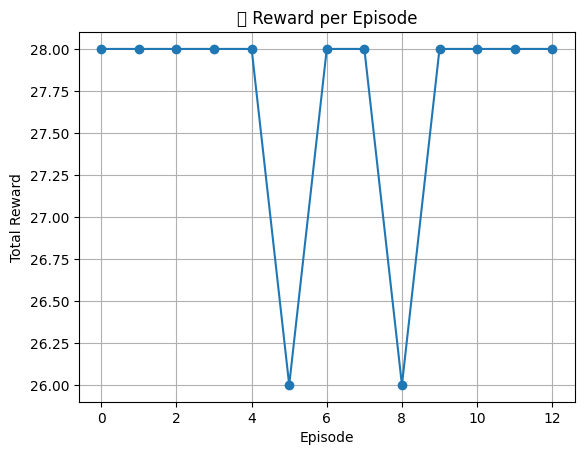

In [44]:
# 📊 Cell E: Plot Rewards
import matplotlib.pyplot as plt

plt.plot(reward_per_episode, marker='o')
plt.title("📉 Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()


In [45]:
# 🧪 Cell F: Minimal Demo (One Run)
state = env.reset()
total_reward = 0
while state is not None:
    with torch.no_grad():
        q = model(state)
    action = torch.argmax(q).item()
    state, reward, done, meta = env.step(action)
    print(f"🖼 {meta['file']} | Action: {'✅ Accept' if action==0 else '🚩 Flag'} | Recon Error: {meta['error']:.5f} | Reward: {reward}")
    total_reward += reward
    if done:
        break

print(f"\n🎓 Final Evaluation Reward: {total_reward}")


🖼 000001.jpg | Action: ✅ Accept | Recon Error: 0.00663 | Reward: 1
🖼 000002.jpg | Action: ✅ Accept | Recon Error: 0.00700 | Reward: -1
🖼 000003.jpg | Action: ✅ Accept | Recon Error: 0.00787 | Reward: 1
🖼 000004.jpg | Action: ✅ Accept | Recon Error: 0.00766 | Reward: 1
🖼 000005.jpg | Action: ✅ Accept | Recon Error: 0.00251 | Reward: 1
🖼 000006.jpg | Action: ✅ Accept | Recon Error: 0.00703 | Reward: 1
🖼 000007.jpg | Action: ✅ Accept | Recon Error: 0.00182 | Reward: 1
🖼 000008.jpg | Action: ✅ Accept | Recon Error: 0.00243 | Reward: 1
🖼 000009.jpg | Action: ✅ Accept | Recon Error: 0.00646 | Reward: 1
🖼 000010.jpg | Action: ✅ Accept | Recon Error: 0.00290 | Reward: 1
🖼 000011.jpg | Action: ✅ Accept | Recon Error: 0.00138 | Reward: 1
🖼 000012.jpg | Action: ✅ Accept | Recon Error: 0.00311 | Reward: 1
🖼 000013.jpg | Action: ✅ Accept | Recon Error: 0.00170 | Reward: 1
🖼 000014.jpg | Action: ✅ Accept | Recon Error: 0.00786 | Reward: 1
🖼 000015.jpg | Action: ✅ Accept | Recon Error: 0.01126 | Rewa

**✅ 1. 📄 Feedback CSV Sample File Format**

In [46]:
import pandas as pd

# ✅ Load user feedback from CSV
feedback_df = pd.read_csv("user_feedback.csv")
USER_FEEDBACK = dict(zip(feedback_df["file_name"], feedback_df["feedback"]))


In [52]:
# ✅ RL Agent Evaluation with Decision Log
import torch.nn.functional as F  # ensure F is available

decision_log = []
state = env.reset()
done = False
step = 0
total_reward = 0

while not done and state is not None:
    # 🧠 Get the agent's action for the current image
    with torch.no_grad():
        action_values = model(state)  # state already has shape [1, 3, 128, 128]
        action = torch.argmax(action_values).item()

    # 🖼 Get image details and reconstruction error
    image_name = env.images[env.index]
    image_path = os.path.join(IMAGE_DIR, image_name)
    image_tensor = env.transform(Image.open(image_path).convert("RGB")).unsqueeze(0).to(DEVICE)
    
    recon = autoencoder(image_tensor)
    recon_error = F.mse_loss(recon, image_tensor).item()

    # 📝 Log the step's data
    decision_log.append({
        "Step": step,
        "Image": image_name,
        "Action": "✅ Accept" if action == 0 else "⚠️ Flag",
        "Recon Error": round(recon_error, 5)
    })

    # 🔁 Step through the environment — FIXED: unpack all 4 return values
    next_state, reward, done, _ = env.step(action)
    total_reward += reward
    state = next_state
    step += 1

print(f"✅ Evaluation Complete | Total Reward: {total_reward}")


✅ Evaluation Complete | Total Reward: 28


What This Cell Does:
Runs the trained RL agent step-by-step.

Uses the autoencoder to calculate reconstruction error per image.

Logs the agent’s decision (Accept or Flag) with recon error.

Collects everything in a decision_log list, ready for visualization or saving.

Handles the extra info return value from env.step() to avoid unpacking errors.

C:\Users\HP\AppData\Local\Temp\ipykernel_1772\218779124.py:19: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_1772\218779124.py:24: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.savefig(chart_path)


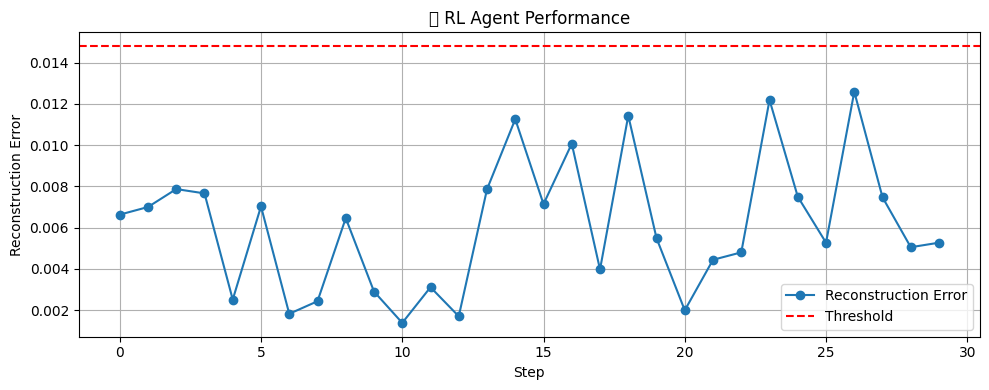

✅ Chart saved to: reports/rl_agent_performance.png


In [55]:
# 📊 Cell C: 
# Visualize & Save Performance Chart
# Plot and Save Reconstruction Error Chart
import matplotlib.pyplot as plt
import pandas as pd

# Convert decision log to DataFrame
results_df = pd.DataFrame(decision_log)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(results_df['Step'], results_df['Recon Error'], marker='o', label='Reconstruction Error')
plt.axhline(y=THRESHOLD, color='r', linestyle='--', label='Threshold')
plt.title("🔍 RL Agent Performance")
plt.xlabel("Step")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
os.makedirs("reports", exist_ok=True)
chart_path = "reports/rl_agent_performance.png"
plt.savefig(chart_path)
plt.show()
print(f"✅ Chart saved to: {chart_path}")


In [56]:
# 💾 Cell D: Save Logs as CSV and HTML
csv_path = "reports/rl_agent_decision_log.csv"
html_path = "reports/rl_agent_decision_log.html"

# Save as CSV
results_df.to_csv(csv_path, index=False)

# Save as HTML (with encoding fix)
results_df.to_html(html_path, index=False, escape=False)

print(f"✅ Logs saved to:\n- CSV: {csv_path}\n- HTML: {html_path}")


✅ Logs saved to:
- CSV: reports/rl_agent_decision_log.csv
- HTML: reports/rl_agent_decision_log.html
